In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os, sys
import pandas as pd
import yaml


root_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath("."))))
sys.path.append(root_dir)

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple
from scipy.stats import sem, t
import torch
import pickle

import seaborn as sns
sns.set_theme()

In [8]:
def tuple_constructor(loader, node):
    return tuple(loader.construct_sequence(node))


def generic_constructor(loader, tag_suffix, node):
    if isinstance(node, yaml.MappingNode):
        # Attempt to handle unhashable keys by converting them to a string representation
        # This is a workaround and might need adjustment based on specific use cases
        return {
            str(loader.construct_object(key)): loader.construct_object(value)
            for key, value in node.value
        }
    elif isinstance(node, yaml.SequenceNode):
        return [loader.construct_object(child) for child in node.value]
    elif isinstance(node, yaml.ScalarNode):
        return loader.construct_scalar(node)
    
yaml.SafeLoader.add_constructor("tag:yaml.org,2002:python/tuple", tuple_constructor)
yaml.SafeLoader.add_multi_constructor("", generic_constructor)

In [9]:
root_dir = r".\results\2024Aug06-154719_config_sparse_rb" # bigger room, big network

### Look at the metrics

In [10]:
def parse_title_string(input_string, prefix=""):
    key_value_pairs = input_string.split("; ")
    result_dict = {}
    
    for pair in key_value_pairs:
        key, value = pair.split("=")
        result_dict[f"{prefix}{key}"] = value
    
    return result_dict

def flatten_metrics(metrics, prefix):
    # Initialize an empty list to collect processed data
    data = []

    # Iterate over each metric log
    for metric in metrics:
        
        # Flatten the nested dictionary structure for each metric log
        flat_metric = {
            f"{prefix}_frame_stamp": metric["frame_stamp"],
        }

        if "epsilon_greedy" in metric:
            flat_metric[f"{prefix}_epsilon_greedy"] = metric["epsilon_greedy"]

        metric_keys = ["episode_rewards", "episode_frames", "episode_losses", "episode_max_qs"]

        # Iterate over each metric key
        for key in metric_keys:
            # Check if the metric key exists in the metric dictionary
            if key in metric:
                # Add the corresponding statistics to flat_metric
                for stat_name, value in metric[key].items():
                    flat_metric[f"{prefix}_{key}_{stat_name}"] = value

                # Append the flattened metric to the data list
                data.append(flat_metric)

    # Convert the data list to a DataFrame
    return pd.DataFrame(data)


def collect_experiment_data_per_epoch(root_dir):
    """
    Collects experiment data and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected data and parameters.
    """
    all_data = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith("inverted_pendulum_train_stats"):
                # Path to the current metrics file
                file_path = os.path.join(subdir, file)

                # Load the metrics data with torch
                try:
                    metrics_data = torch.load(file_path)
                except FileNotFoundError:
                    print(f"Metrics file not found: {file_path}. Skipping...")
                    continue

                # Process the metrics data
                df_training_metrics = flatten_metrics(
                    metrics_data.get("training_stats", []), "training"
                )
                df_validation_metrics = flatten_metrics(
                    metrics_data.get("validation_stats", []), "validation"
                )

                # Combine training and validation metrics if both are available
                if not df_training_metrics.empty and not df_validation_metrics.empty:
                    df_metrics = pd.concat(
                        [df_training_metrics, df_validation_metrics], axis=1
                    )
                elif not df_training_metrics.empty:
                    df_metrics = df_training_metrics
                else:
                    df_metrics = df_validation_metrics

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                try:
                    with open(cfg_path, "r") as cfg_file:
                        cfg_data = yaml.safe_load(cfg_file)
                except FileNotFoundError:
                    print(f"Configuration file not found for {file_path}. Skipping...")
                    continue

                # Extract parameters from the configuration file
                for param, value in cfg_data.items():
                    if isinstance(value, dict):
                        for sub_param, sub_value in value.items():
                            df_metrics[f"{param}_{sub_param}"] = sub_value
                    elif isinstance(value, tuple):
                        df_metrics[param] = str(value)
                    elif isinstance(value, list):
                        df_metrics[param] = str(value)
                    else:
                        df_metrics[param] = value
                        
                if "title" in cfg_data:
                    title_args_dict = parse_title_string(cfg_data.get("title"), prefix="exp_arg_")
                    for key, value in title_args_dict.items():
                        df_metrics[key] = value
                        
                # Append to the list of all data
                all_data.append(df_metrics)

    # Concatenate all data into a single DataFrame if not empty, otherwise return an empty DataFrame
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()


# Example usage:
combined_data = collect_experiment_data_per_epoch(root_dir)
combined_data

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_7276\167957205.py:118: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_data, ignore_index=True)


,training_frame_stamp,training_epsilon_greedy,training_episode_rewards_min,training_episode_rewards_max,training_episode_rewards_mean,training_episode_rewards_median,training_episode_rewards_std,training_episode_frames_min,training_episode_frames_max,training_episode_frames_mean,...,replay_buffer_type,run_id,seed,title,train_max_iterations,exp_arg_optim.args_.eps,exp_arg_optim.args_.lr,exp_arg_replay_buffer.knn_neighbors,exp_arg_replay_buffer.sample_distance_threshold,exp_arg_agent_params.args_.hidden_size
0,10000,0.9703,160.827661,267.636200,196.403771,189.298899,28.363767,1000,1000,1000.000000,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
1,10000,0.9703,160.827661,267.636200,196.403771,189.298899,28.363767,1000,1000,1000.000000,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
2,10000,0.9703,160.827661,267.636200,196.403771,189.298899,28.363767,1000,1000,1000.000000,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
3,10000,0.9703,160.827661,267.636200,196.403771,189.298899,28.363767,1000,1000,1000.000000,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
4,20000,0.9373,189.808691,272.856999,219.387462,219.011344,21.862892,1000,1000,1000.000000,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23035,590000,0.0100,96.530658,605.381354,133.856746,105.293067,92.886727,177,1000,277.472222,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-06; optim.args_.lr=0.01; re...,60,1e-06,0.01,10,2,128
23036,600000,0.0100,97.114535,608.287397,142.369633,106.193029,128.122429,177,1000,247.756098,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-06; optim.args_.lr=0.01; re...,60,1e-06,0.01,10,2,128
23037,600000,0.0100,97.114535,608.287397,142.369633,106.193029,128.122429,177,1000,247.756098,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-06; optim.args_.lr=0.01; re...,60,1e-06,0.01,10,2,128
23038,600000,0.0100,97.114535,608.287397,142.369633,106.193029,128.122429,177,1000,247.756098,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-06; optim.args_.lr=0.01; re...,60,1e-06,0.01,10,2,128


In [11]:
combined_data.columns

Index(['training_frame_stamp', 'training_epsilon_greedy',
       'training_episode_rewards_min', 'training_episode_rewards_max',
       'training_episode_rewards_mean', 'training_episode_rewards_median',
       'training_episode_rewards_std', 'training_episode_frames_min',
       'training_episode_frames_max', 'training_episode_frames_mean',
       'training_episode_frames_median', 'training_episode_frames_std',
       'training_episode_losses_min', 'training_episode_losses_max',
       'training_episode_losses_mean', 'training_episode_losses_median',
       'training_episode_losses_std', 'training_episode_max_qs_min',
       'training_episode_max_qs_max', 'training_episode_max_qs_mean',
       'training_episode_max_qs_median', 'training_episode_max_qs_std',
       'validation_frame_stamp', 'validation_episode_rewards_min',
       'validation_episode_rewards_max', 'validation_episode_rewards_mean',
       'validation_episode_rewards_median', 'validation_episode_rewards_std',
       'va

In [12]:
[col for col in combined_data.columns if "exp_arg_" in col]


['exp_arg_optim.args_.eps',
 'exp_arg_optim.args_.lr',
 'exp_arg_replay_buffer.knn_neighbors',
 'exp_arg_replay_buffer.sample_distance_threshold',
 'exp_arg_agent_params.args_.hidden_size']

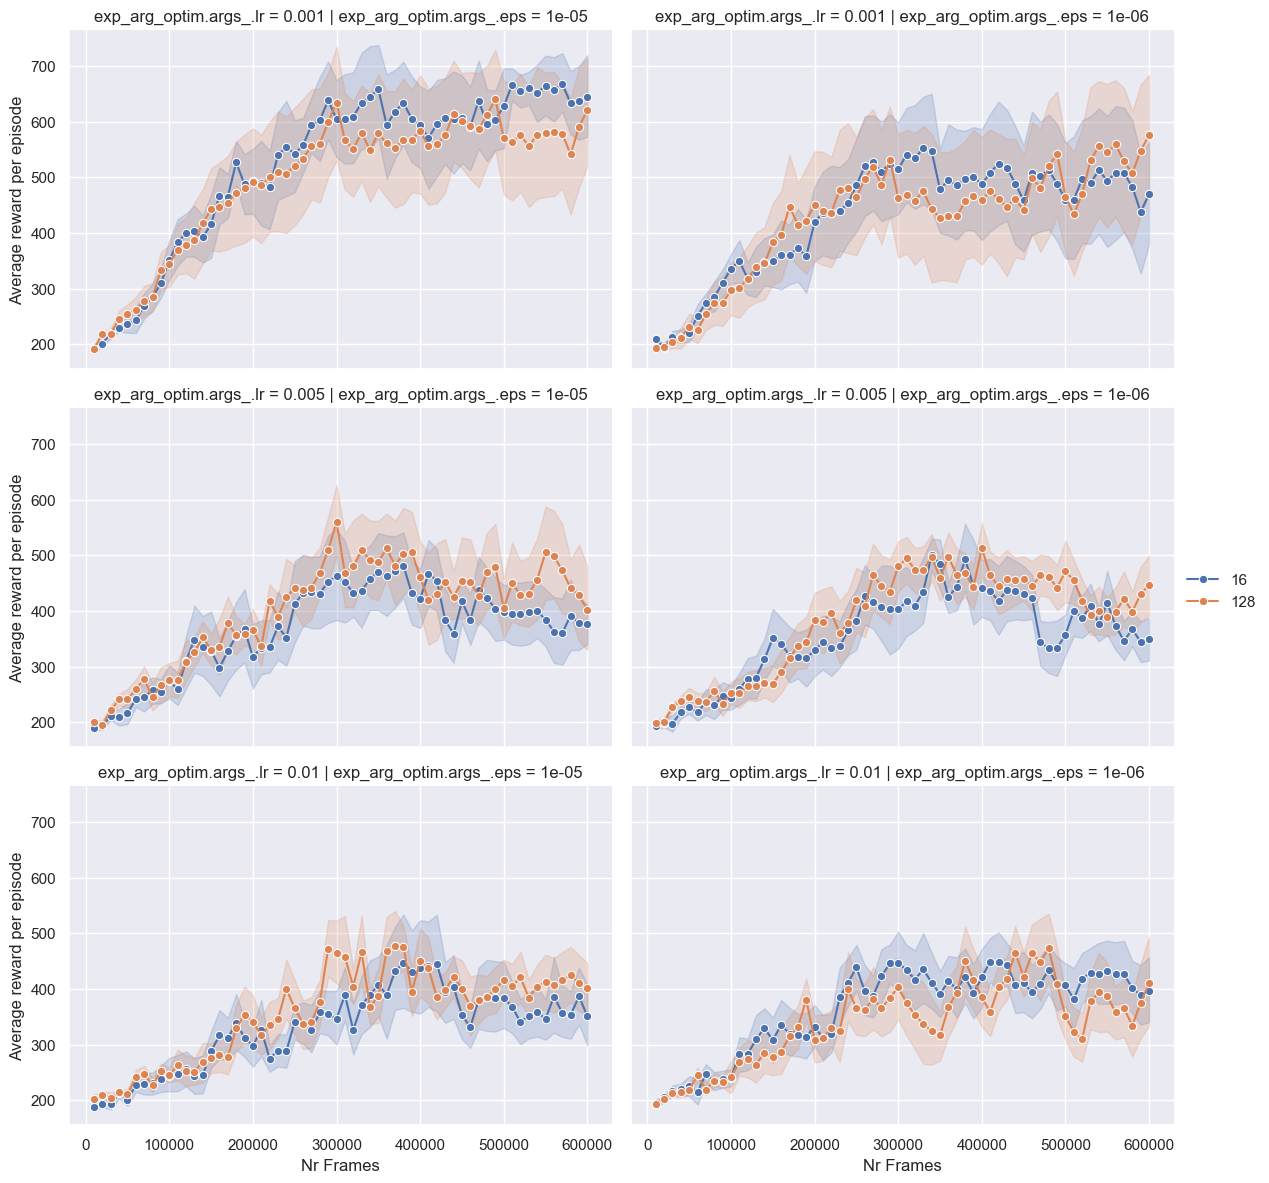

In [13]:
g = sns.FacetGrid(
    combined_data,
    row="exp_arg_optim.args_.lr",
    col="exp_arg_optim.args_.eps",
    # col_wrap=3,
    height=4,
    aspect=1.5,
)

# Map the lineplot to the FacetGrid
g.map_dataframe(
    sns.lineplot,
    x="training_frame_stamp",
    y="training_episode_rewards_mean",
    hue="exp_arg_agent_params.args_.hidden_size",
    marker="o",
    errorbar="ci",
)

# Add axis labels and titles
g.set_axis_labels("Nr Frames", "Average reward per episode")
g.add_legend()

# Display the plot
plt.show()

In [25]:
combined_data

,training_frame_stamp,training_epsilon_greedy,training_episode_rewards_min,training_episode_rewards_max,training_episode_rewards_mean,training_episode_rewards_median,training_episode_rewards_std,training_episode_frames_min,training_episode_frames_max,training_episode_frames_mean,...,replay_buffer_type,run_id,seed,title,train_max_iterations,exp_arg_optim.args_.eps,exp_arg_optim.args_.lr,exp_arg_replay_buffer.knn_neighbors,exp_arg_replay_buffer.sample_distance_threshold,exp_arg_agent_params.args_.hidden_size
0,10000,0.9703,160.827661,267.636200,196.403771,189.298899,28.363767,1000,1000,1000.000000,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
1,10000,0.9703,160.827661,267.636200,196.403771,189.298899,28.363767,1000,1000,1000.000000,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
2,10000,0.9703,160.827661,267.636200,196.403771,189.298899,28.363767,1000,1000,1000.000000,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
3,10000,0.9703,160.827661,267.636200,196.403771,189.298899,28.363767,1000,1000,1000.000000,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
4,20000,0.9373,189.808691,272.856999,219.387462,219.011344,21.862892,1000,1000,1000.000000,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23035,590000,0.0100,96.530658,605.381354,133.856746,105.293067,92.886727,177,1000,277.472222,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-06; optim.args_.lr=0.01; re...,60,1e-06,0.01,10,2,128
23036,600000,0.0100,97.114535,608.287397,142.369633,106.193029,128.122429,177,1000,247.756098,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-06; optim.args_.lr=0.01; re...,60,1e-06,0.01,10,2,128
23037,600000,0.0100,97.114535,608.287397,142.369633,106.193029,128.122429,177,1000,247.756098,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-06; optim.args_.lr=0.01; re...,60,1e-06,0.01,10,2,128
23038,600000,0.0100,97.114535,608.287397,142.369633,106.193029,128.122429,177,1000,247.756098,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-06; optim.args_.lr=0.01; re...,60,1e-06,0.01,10,2,128


In [27]:
# Select best lr eps combo
sub_combined_data = combined_data[
    (combined_data["exp_arg_optim.args_.lr"]=="0.001")
    & (combined_data["exp_arg_optim.args_.eps"]=="1e-05")]

sub_combined_data

,training_frame_stamp,training_epsilon_greedy,training_episode_rewards_min,training_episode_rewards_max,training_episode_rewards_mean,training_episode_rewards_median,training_episode_rewards_std,training_episode_frames_min,training_episode_frames_max,training_episode_frames_mean,...,replay_buffer_type,run_id,seed,title,train_max_iterations,exp_arg_optim.args_.eps,exp_arg_optim.args_.lr,exp_arg_replay_buffer.knn_neighbors,exp_arg_replay_buffer.sample_distance_threshold,exp_arg_agent_params.args_.hidden_size
0,10000,0.9703,160.827661,267.636200,196.403771,189.298899,28.363767,1000,1000,1000.0,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
1,10000,0.9703,160.827661,267.636200,196.403771,189.298899,28.363767,1000,1000,1000.0,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
2,10000,0.9703,160.827661,267.636200,196.403771,189.298899,28.363767,1000,1000,1000.0,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
3,10000,0.9703,160.827661,267.636200,196.403771,189.298899,28.363767,1000,1000,1000.0,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
4,20000,0.9373,189.808691,272.856999,219.387462,219.011344,21.862892,1000,1000,1000.0,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,5,0.1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,590000,0.0100,192.355281,242.139181,222.158867,232.096150,19.565991,1000,1000,1000.0,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,10,2,128
3836,600000,0.0100,193.224172,242.675505,224.151410,227.632260,16.413725,1000,1000,1000.0,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,10,2,128
3837,600000,0.0100,193.224172,242.675505,224.151410,227.632260,16.413725,1000,1000,1000.0,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,10,2,128
3838,600000,0.0100,193.224172,242.675505,224.151410,227.632260,16.413725,1000,1000,1000.0,...,SparseReplayBuffer,0,None,optim.args_.eps=1e-05; optim.args_.lr=0.001; r...,60,1e-05,0.001,10,2,128


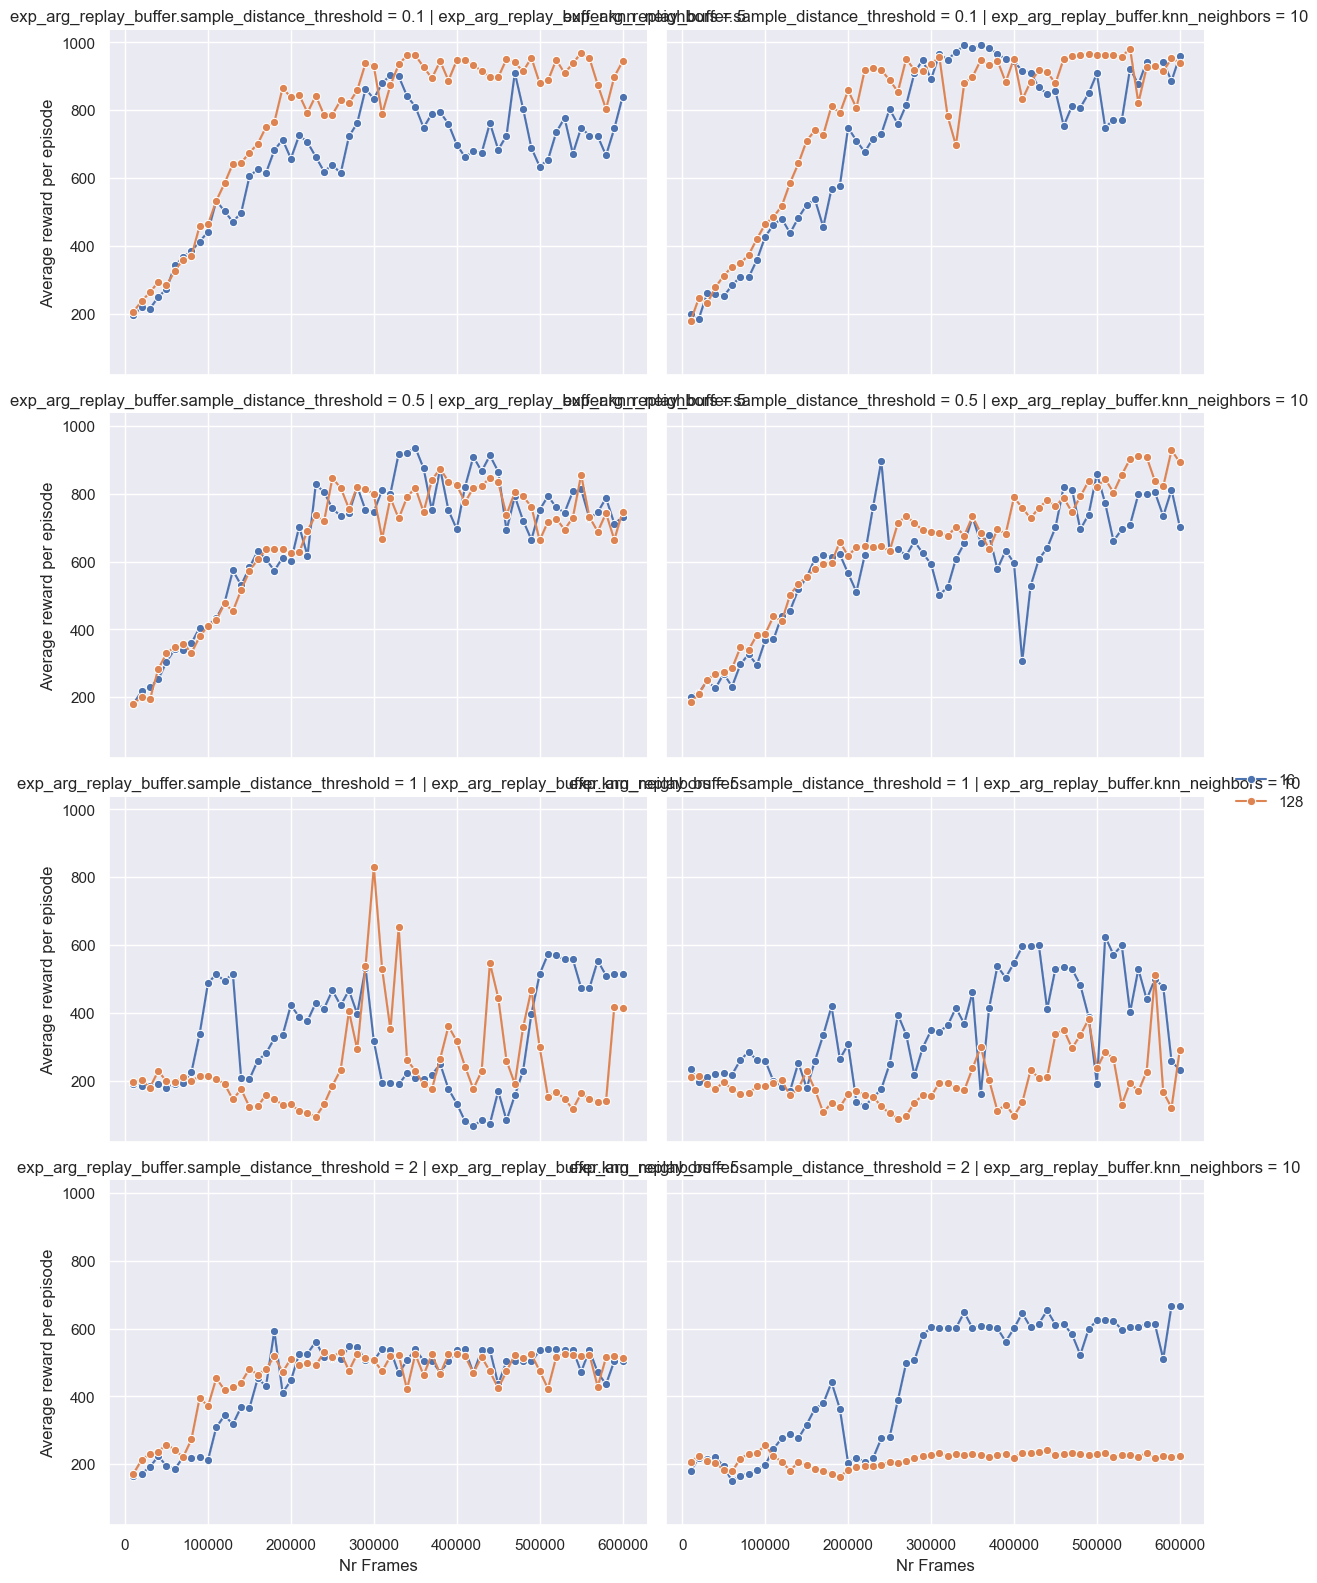

In [28]:


g = sns.FacetGrid(
    sub_combined_data,
    row="exp_arg_replay_buffer.sample_distance_threshold",
    col="exp_arg_replay_buffer.knn_neighbors",
    # col_wrap=3,
    height=4,
    aspect=1.5,
)

# Map the lineplot to the FacetGrid
g.map_dataframe(
    sns.lineplot,
    x="training_frame_stamp",
    y="training_episode_rewards_mean",
    hue="exp_arg_agent_params.args_.hidden_size",
    marker="o",
    errorbar="ci",
)

# Add axis labels and titles
g.set_axis_labels("Nr Frames", "Average reward per episode")
g.add_legend()

# Display the plot
plt.show()

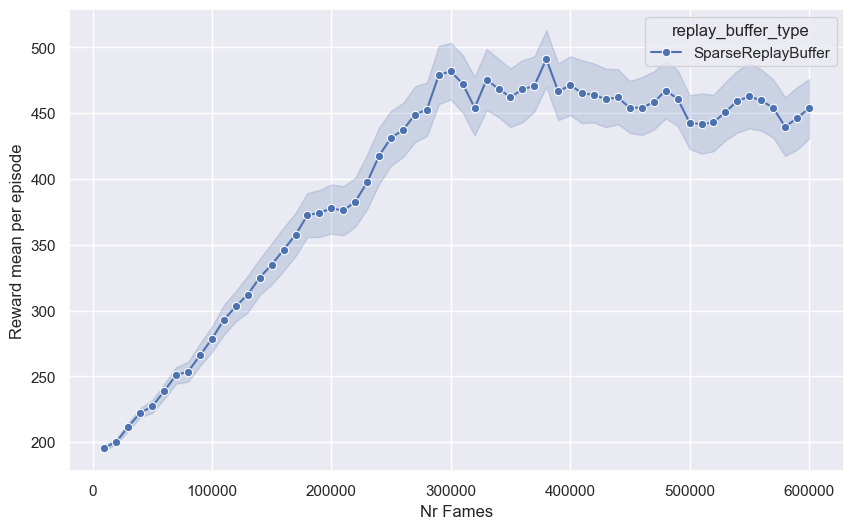

In [14]:
plt.figure(figsize=(10, 6))

# Plot experiment data
sns.lineplot(
    data=combined_data,
    x="training_frame_stamp",
    y="training_episode_rewards_mean",
    hue="replay_buffer_type",
    marker="o",
    errorbar="ci",
    #  errorbar=("pi", 100)
)

plt.xlabel("Nr Fames")
plt.ylabel("Reward mean per episode")
# plt.xscale("log")
# plt.yscale("log")

plt.show()

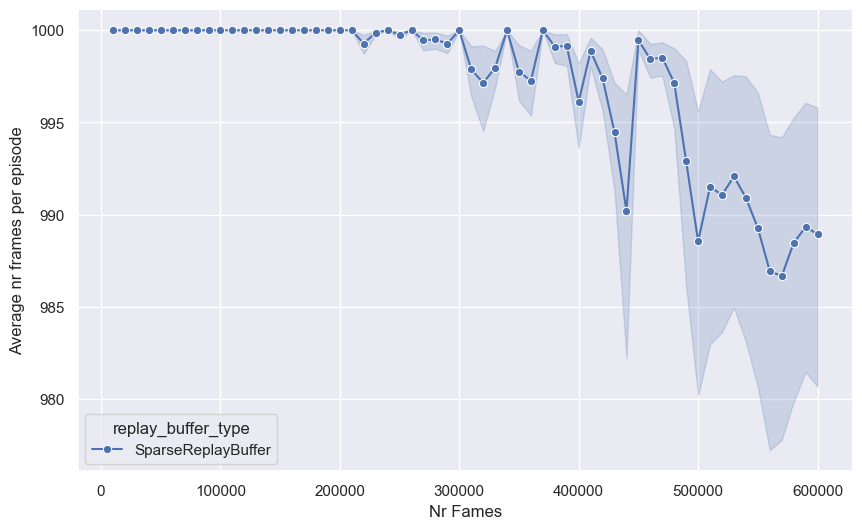

In [15]:
plt.figure(figsize=(10, 6))

# Plot experiment data
sns.lineplot(
    data=combined_data,
    x="training_frame_stamp",
    y="training_episode_frames_mean",
    hue="replay_buffer_type",
    marker="o",
    errorbar="ci",
    #  errorbar=("pi", 100)
)

plt.xlabel("Nr Fames")
plt.ylabel("Average nr frames per episode")
# plt.xscale("log")
# plt.yscale("log")

plt.show()

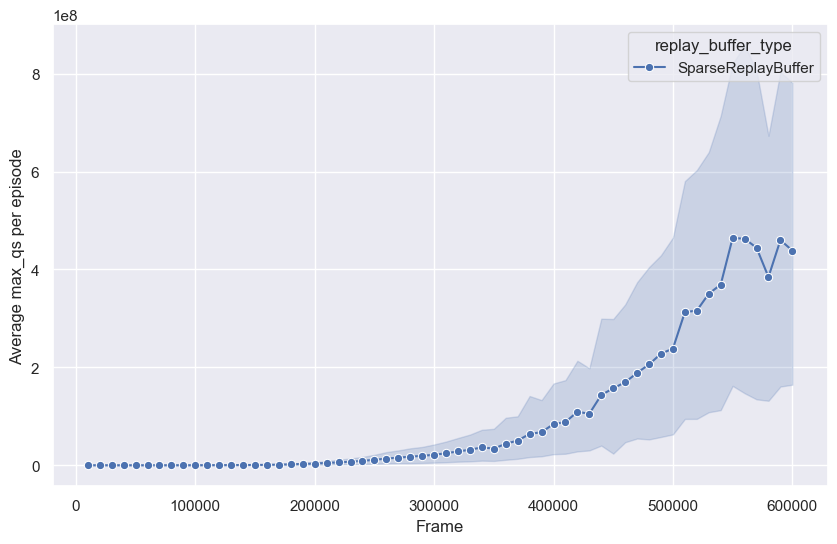

In [16]:
plt.figure(figsize=(10, 6))

# Plot experiment data
sns.lineplot(
    data=combined_data,
    x="training_frame_stamp",
    y="training_episode_max_qs_mean",
    hue="replay_buffer_type",
    marker="o",
    errorbar="ci",
    #  errorbar=("pi", 100)
)


# Adjustments to plot aesthetics
plt.xlabel("Frame")
plt.ylabel("Average max_qs per episode")
# plt.xscale("log")
# plt.yscale("log")

plt.show()

In [17]:
# Skip below

In [18]:
# Assuming baseline_errors_df is your dataframe
n = len(baseline_errors_df["validation_error"])  # Number of samples
baseline_avg_bellman_error = baseline_errors_df["validation_error"].mean()
baseline_std_dev = baseline_errors_df["validation_error"].std()
baseline_sem = sem(
    baseline_errors_df["validation_error"], nan_policy="omit"
)  # Calculate the SEM

# Confidence interval calculation (95% confidence)
t_critical = t.ppf(0.975, n - 1)  # Two-tailed t-value for 95% confidence
ci_range = t_critical * baseline_sem

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=experiment_data_df,
    x="tau",
    y="bellman_error",
    hue="model",
    marker="o",
    errorbar="ci",
    #  errorbar=("pi", 100)
)

tau_min = experiment_data_df["tau"].min()
tau_max = experiment_data_df["tau"].max()

# Plot the mean line
plt.plot(
    [tau_min, tau_max],
    [baseline_avg_bellman_error, baseline_avg_bellman_error],
    linestyle="--",
    color="darkred",
)

# Plot the confidence interval around the mean
x_values = np.logspace(np.log10(tau_min), np.log10(tau_max), num=100)

plt.fill_between(
    x_values,
    [baseline_avg_bellman_error - ci_range] * len(x_values),
    [baseline_avg_bellman_error + ci_range] * len(x_values),
    color="darkred",
    alpha=0.2,
    label="Baseline - validation error",
)

plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")
plt.legend()

plt.show()

NameError: name 'baseline_errors_df' is not defined

In [ ]:
# # With access to seeds, check why some examles have much lower bellman errors:

# from common.src.distribution_src import (
#     train_net_with_neural_fitting,
#     generate_random_policy_transitions,
#     generate_transitions_observations,
#     generate_train_test_split_with_valid_path,
#     make_env,
# )
# from common.src.experiment_utils import setup_logger, seed_everything

# seed = 3
# start_state = (0, 0)
# terminal_states = {(8, 8): 1}
# rows = 10
# cols = 10
# p_success = 1.0
# num_steps = 40_000
# tau = 10
# min_samples = 10


# def experiment_sample(
#     seed,
#     start_state,
#     terminal_states,
#     rows,
#     cols,
#     p_success,
#     num_steps,
#     tau,
#     min_samples,
# ):
#     seed_everything(seed)

#     env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

#     states = list(set([s for s, _ in env.mdp.keys()]))
#     actions = list(set([a for _, a in env.mdp.keys()]))

#     transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

#     transitions_train, transitions_val = generate_train_test_split_with_valid_path(
#         transitions_list=transitions_list,
#         start_state=start_state,
#         terminal_states=terminal_states,
#         seed=seed,
#     )

#     train_dataset_transitions = generate_transitions_observations(
#         transitions_train, num_steps, tau, min_samples=min_samples
#     )

#     return train_dataset_transitions


# samples = experiment_sample(
#     seed,
#     start_state,
#     terminal_states,
#     rows,
#     cols,
#     p_success,
#     num_steps,
#     tau,
#     min_samples,
# )

In [ ]:
# def sum_rewards(transitions):
#     return sum(transition[3] for transition in transitions)


# def count_transitions_terminal(transitions, target_value=1.0):
#     transition_counts = {}
#     for transition in transitions:
#         if transition[3] == target_value:
#             key = tuple(transition[:3])
#             transition_counts[key] = transition_counts.get(key, 0) + 1
#     return transition_counts


# def count_transitions(transitions):
#     transition_counts = {}
#     for transition in transitions:
#         key = tuple(transition[:3])
#         transition_counts[key] = transition_counts.get(key, 0) + 1
#     return transition_counts


# samples = experiment_sample(
#     seed,
#     start_state,
#     terminal_states,
#     rows,
#     cols,
#     p_success,
#     num_steps,
#     tau,
#     min_samples,
# )

# sum_rewards(samples)
# t_counts = count_transitions(samples)
# # len(t_counts)
# # t_counts

In [ ]:
# def process_row(row):
#     try:

#         terminal_states = {(8, 8): 1.0}

#         start_state = (1, 1)

#         train_dataset_transitions = experiment_sample(

#             seed=row["seed"],
#             start_state=start_state,
#             terminal_states=terminal_states,

#             rows=row["rows"],

#             cols=row["cols"],

#             p_success=row["p_success"],

#             num_steps=row["num_steps"],

#             tau=row["tau"],

#             min_samples=row["min_samples"],

#         )


#         sum_of_rewards = sum_rewards(train_dataset_transitions)

#         terminal_t_counts = count_transitions_terminal(train_dataset_transitions)

#         transition_counts = count_transitions(train_dataset_transitions)


#     except Exception as e:
#         print(row.to_dict())
#         raise e


#     # Assuming the count_transitions function returns a count you want directly; if it's more complex, adjust accordingly.

#     return pd.Series(
#         [sum_of_rewards, len(terminal_t_counts), len(transition_counts)],
#         index=["sum_rewards", "distinct_terminal_states", "distinct_transitions"],
#     )



# results_df = bellman_errors_df.apply(process_row, axis=1)


# # Concatenate the new results with the original DataFrame

# df_with_results = pd.concat([bellman_errors_df, results_df], axis=1)

# df_with_results

In [ ]:
# fail_dict = {'model': 'qnet_original',
#              'bellman_error': 0.3328666090965271,
#              'alpha': 0.1,
#              'batch_size': 32,
#              'cfg_id': 1,
#              'cols': 10,
#              'epsilon': 0.01,
#              'experiment': 'experiment_distributions',
#              'experiment_arguments_min_samples': 10,
#              'experiment_arguments_tau': 0.01,
#              'full_title': '2024Apr15-163128_configs_tau=0.01; min_samples=10',
#              'gamma': 0.9,
#              'min_samples': 10,
#              'num_steps': 40000,
#              'out_dir': '.\\results\\2024Apr15-163128_configs\\0001_tau_0.01__min_samples_10\\12',
#              'p_success': 1,
#              'rows': 10,
#              'run_id': 12,
#              'seed': 3211944324,
#              'start_state': 1,
#              'tau': 0.01,
#              'terminal_states_(8, 8)': 1.0,
#              'title': 'tau=0.01; min_samples=10',
#              'train_max_iterations': 30}

# seed = fail_dict["seed"]
# rows = fail_dict["rows"]
# cols = fail_dict["cols"]
# p_success = fail_dict["p_success"]
# num_steps = fail_dict["num_steps"]
# tau = fail_dict["tau"]
# min_samples = fail_dict["min_samples"]
# terminal_states = {(8, 8): 1.0}
# start_state = (1, 1)

# seed_everything(seed)

# env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

# states = list(set([s for s, _ in env.mdp.keys()]))
# actions = list(set([a for _, a in env.mdp.keys()]))

# transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

# transitions_train, transitions_val = generate_train_test_split_with_valid_path(
#     transitions_list=transitions_list,
#     start_state=start_state,
#     terminal_states=terminal_states,
#     seed=seed,
# )

# # train_dataset_transitions = generate_transitions_observations(
# #     transitions_train, num_steps, tau, min_samples=min_samples
# # )

In [ ]:
# sns.scatterplot(
#     data=df_with_results, x="distinct_transitions", y="bellman_error", hue="model"
# )

# # plt.xscale("log")

# plt.yscale("log")

# plt.show()

In [ ]:
# sns.scatterplot(data=df_with_results, x="sum_rewards", y="bellman_error", hue="model")
# # plt.xscale("log")
# plt.yscale("log")
# plt.show()

In [ ]:
# sns.scatterplot(
#     data=df_with_results, x="distinct_terminal_states", y="bellman_error", hue="model"
# )

# # plt.xscale("log")

# plt.yscale("log")

# plt.show()

### Plot distributions of transitions

In [ ]:
# def plot_state_counts_heatmap(transitions, title="State Counts"):
#     # Convert dataset to DataFrame
#     columns = ["state", "action", "next_state", "reward", "done", "prob"]
#     df = pd.DataFrame(transitions, columns=columns)

#     # Split state and next_state into separate columns for rows and cols
#     df[["state_row", "state_col"]] = pd.DataFrame(df["state"].tolist(), index=df.index)
#     df[["next_state_row", "next_state_col"]] = pd.DataFrame(
#         df["next_state"].tolist(), index=df.index
#     )

#     # Group by state positions to count occurrences
#     train_state_counts = (
#         df.groupby(["state_row", "state_col"]).size().reset_index(name="counts")
#     )

#     # Pivot the counts data for heatmap plotting
#     train_state_heatmap = train_state_counts.pivot(
#         index="state_row", columns="state_col", values="counts"
#     )

#     # Plotting
#     plt.figure(figsize=(12, 6))
#     sns.heatmap(train_state_heatmap, annot=False, cmap="YlGnBu", cbar=True)
#     plt.title(title)
#     plt.xlabel("State Column")
#     plt.ylabel("State Row")
#     plt.show()

In [ ]:
# idx_min = bellman_errors_df.groupby("tau")["bellman_error"].idxmin()
# idx_max = bellman_errors_df.groupby("tau")["bellman_error"].idxmax()

# # Use the indices to select the rows
# min_bellman_errors_df = bellman_errors_df.loc[idx_min]
# max_bellman_errors_df = bellman_errors_df.loc[idx_max]

# # Combine the min and max rows into a single DataFrame
# # To ensure no duplicates if min and max are the same row, use pd.concat with drop_duplicates
# result_df = pd.concat([min_bellman_errors_df, max_bellman_errors_df]).drop_duplicates()

# ### Histogram of transitions

# for index, row in result_df.iterrows():

#     terminal_states = {(8, 8): 1.0}

#     start_state = (1, 1)


#     # Call experiment_sample with the current row's data

#     train_dataset_transitions = experiment_sample(
#         seed=row["seed"],
#         start_state=start_state,
#         terminal_states=terminal_states,
#         rows=row["rows"],
#         cols=row["cols"],
#         p_success=row["p_success"],
#         num_steps=row["num_steps"],
#         tau=row["tau"],
#         min_samples=row["min_samples"],
#     )

#     plot_state_counts_heatmap(train_dataset_transitions, title=f"{row['tau']}")

#     # # Compute the desired metrics
#     # sum_of_rewards = sum_rewards(train_dataset_transitions)
#     # terminal_t_counts = count_transitions_terminal(train_dataset_transitions)
#     # transition_counts = count_transitions(train_dataset_transitions)

#     # data = {

#     #     "Transitions": [f"{key[0]} {key[1]} {key[2]}" for key in transition_counts.keys()],

#     #     "Counts": list(transition_counts.values())

#     # }


#     # df = pd.DataFrame(data)

#     # plt.figure(figsize=(10, 6))

#     # sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


#     # # Adding titles and labels

#     # plt.title(f'{row["model"]}, {row["tau"]}, {row["min_samples"]}, {row["bellman_error"]}')

#     # plt.xlabel('Transitions')

#     # plt.ylabel('Counts')

#     # # plt.xticks(rotation=90, ha="right")
#     # plt.xticks([])


#     # # Display the plot

#     # plt.tight_layout()

#     # plt.show()

In [ ]:
# # Assuming your DataFrame is named df
# sns.set_theme(style="whitegrid")  # Setting the theme for the plots

# plt.figure(figsize=(10, 6))  # Setting the figure size
# ax = sns.barplot(
#     x="model",
#     y="bellman_error",
#     data=bellman_errors_df,
#     ci="sd",
#     palette="coolwarm",
#     capsize=0.2,
# )

# plt.title("Bellman Error by Model with Confidence Interval")
# plt.ylabel("Bellman Error")
# plt.xlabel("Model")
# plt.yscale(
#     "log"
# )  # Optional: use logarithmic scale for better visualization of wide value ranges

# plt.show()